<a href="https://colab.research.google.com/github/Syilun/TibameAI04/blob/master/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import zipfile
f = zipfile.ZipFile("/content/drive/My Drive/train.zip ")
f.extractall('datas') # 千萬不要解壓縮到自己的drive

# 其他壓縮檔: rarfile, gzip

In [17]:
import glob
import pandas as pd
dogs = glob.glob("datas/train/dog.*")
cats = glob.glob("datas/train/cat.*")
df = pd.DataFrame({
    "path":dogs + cats,
    "ans":[0] * len(dogs) + [1] * len(cats)
})
df

,path,ans
0,datas/train/dog.5656.jpg,0
1,datas/train/dog.8713.jpg,0
2,datas/train/dog.6643.jpg,0
3,datas/train/dog.5301.jpg,0
4,datas/train/dog.2056.jpg,0
...,...,...
24995,datas/train/cat.5152.jpg,1
24996,datas/train/cat.3089.jpg,1
24997,datas/train/cat.9365.jpg,1
24998,datas/train/cat.4735.jpg,1


In [51]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential

# 以VGG16當transfer model

cnn = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3), pooling=None, classes=1000)


# 固定transfer model的參數
for layer in cnn.layers:
  layer.trainable = False

mlp = [
      #  加入BatchNormalization()後，增加了512 * 4 = 2048(一半不訓練[原本平均. 標準差], 一半訓練[後來平均, 後來標準差])
       BatchNormalization(),
       GlobalAveragePooling2D(),
       Dense(256, activation='relu'),
       Dense(2, activation='softmax')

]
model = Sequential(cnn.layers + mlp)

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [52]:
cnn.layers

In [53]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer="adam",
       metrics=["accuracy"])

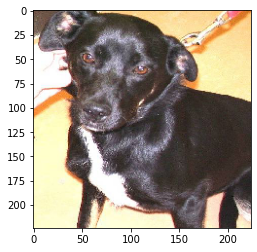

In [54]:
# from tensorflow.keras.losses import
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

img = load_img(df['path'][0], target_size=(224, 224))
plt.imshow(img)



In [55]:
import numpy as np
from sklearn.model_selection import train_test_split
# 只要開始處理資料就不要看到dataframe了，用np.array
x = np.array(df['path'])
y = np.array(df['ans'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [56]:
def test():
  abc = [1, 2, 3, 4, 5]
  for a in abc:
    yield a ** 2
for t in test():
  print('-', t)

# yield 會等你做完你要做的事，再做下一個
# fit_generator 就是使用yield
# 代替方案: train_on_batch

- 1
- 4
- 9
- 16
- 25


In [57]:
from tensorflow.keras.applications.vgg16 import preprocess_input

def get_data(x, y, batch=20):
    idx = np.random.randint(0, len(x), batch)
    x_idx, y_idx = x[idx], y[idx]
    x_ori, x_norm, y_ori = [], [], y_idx
    for p in x_idx:
        img = np.array(load_img(p, target_size=(224, 224)))
        img_pre = preprocess_input(img)
        x_ori.append(img)
        x_norm.append(img_pre)
    return np.array(x_ori), np.array(x_norm), np.array(y_ori)
# get_data(x_train, y_train, 1)
    

# 訓練框架不一定每個都是Tensorflow
# 隨機出來的數值也要跟不同框架Input的規格配合
# caffe: -1xx~1xx
# tf: -1~1
# torch: 
# 所以要去keras.application github上看要transfer的model的preprocess_input當初是用哪個框架
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py


In [58]:
for i in range(10):
    print("[times]:", i)
    _, x_batch, y_batch = get_data(x_train, y_train) # _: 代表不取名的意思，不找變數接它
    result = model.train_on_batch(x_batch, y_batch)
    print("[Train]:", result)
    _, x_batch, y_batch = get_data(x_test, y_test, 100)
    result = model.test_on_batch(x_batch, y_batch)
    print("[Test]:", result)

[times]: 0
[Train]: [0.638410210609436, 0.6000000238418579]
[Test]: [0.5128244161605835, 0.8299999833106995]
[times]: 1
[Train]: [0.6062177419662476, 0.75]
[Test]: [0.40643489360809326, 0.8500000238418579]
[times]: 2
[Train]: [0.45814141631126404, 0.800000011920929]
[Test]: [0.2998615503311157, 0.8999999761581421]
[times]: 3
[Train]: [0.4972446858882904, 0.800000011920929]
[Test]: [0.21186521649360657, 0.9100000262260437]
[times]: 4
[Train]: [0.3532722294330597, 0.949999988079071]
[Test]: [0.182101309299469, 0.9100000262260437]
[times]: 5
[Train]: [0.35141658782958984, 0.8999999761581421]
[Test]: [0.33235007524490356, 0.8899999856948853]
[times]: 6
[Train]: [0.31518447399139404, 0.8999999761581421]
[Test]: [0.1893521547317505, 0.949999988079071]
[times]: 7
[Train]: [0.16412994265556335, 1.0]
[Test]: [0.1201799213886261, 0.9599999785423279]
[times]: 8
[Train]: [0.241918683052063, 0.8999999761581421]
[Test]: [0.17097841203212738, 0.9300000071525574]
[times]: 9
[Train]: [0.272268831729888

In [59]:
model.predict(x_batch)

array([[5.40463813e-02, 9.45953608e-01],
       [1.02462713e-03, 9.98975396e-01],
       [5.68569243e-01, 4.31430787e-01],
       [9.99995828e-01, 4.16679177e-06],
       [5.63302338e-01, 4.36697721e-01],
       [6.77752367e-04, 9.99322295e-01],
       [9.93098080e-01, 6.90194219e-03],
       [8.27821961e-04, 9.99172211e-01],
       [6.77418197e-04, 9.99322653e-01],
       [5.60979962e-01, 4.39020008e-01],
       [9.95629430e-01, 4.37057065e-03],
       [9.99996305e-01, 3.75174727e-06],
       [2.57523984e-01, 7.42475986e-01],
       [6.64596185e-02, 9.33540344e-01],
       [9.98067319e-01, 1.93266722e-03],
       [1.03836335e-01, 8.96163642e-01],
       [9.99959826e-01, 4.01676662e-05],
       [9.92289841e-01, 7.71011598e-03],
       [2.02639140e-02, 9.79736090e-01],
       [9.99893188e-01, 1.06798921e-04],
       [9.97541189e-01, 2.45884084e-03],
       [8.27843130e-01, 1.72156900e-01],
       [8.72159726e-04, 9.99127805e-01],
       [3.98361869e-02, 9.60163891e-01],
       [8.240902

In [60]:
x_ori, x_batch, y_batch = get_data(x_test, y_test, 1000)
model.evaluate(x_batch, y_batch)

32/32 [==============================] - 7s 226ms/step - loss: 0.1337 - accuracy: 0.9470


[0.1336759477853775, 0.9470000267028809]

In [61]:
# 輸出不符合預期輸入，要做nomalization
# transfer 別人的model的輸出必須接上nomalization，再加上我們自己要train的model
# losses為什麼會一直在很大區間跳來跳去？有可能是你輸出進的資料已經遠超過activation function微分後還可以接受的區間了
# (如果是接近兩邊0的地方，基本上不可能update參數，chain rule下來有零整體都是零)
# 1. losses
# 2. predict 的機率完全0,1
# 這兩個地方可以看得出來model結構有問題

In [62]:
# predict_classes 可以用predict().argmax 代替
# 沒指定的畫兩個軸都會做，我們只需要column，所以設定axis=1

# argmax: 找最大值的index, 通常都是最後一個軸(-1)
pre = model.predict(x_batch).argmax(axis=-1)
pre

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,

In [63]:
trans = ["dog", "cat"]

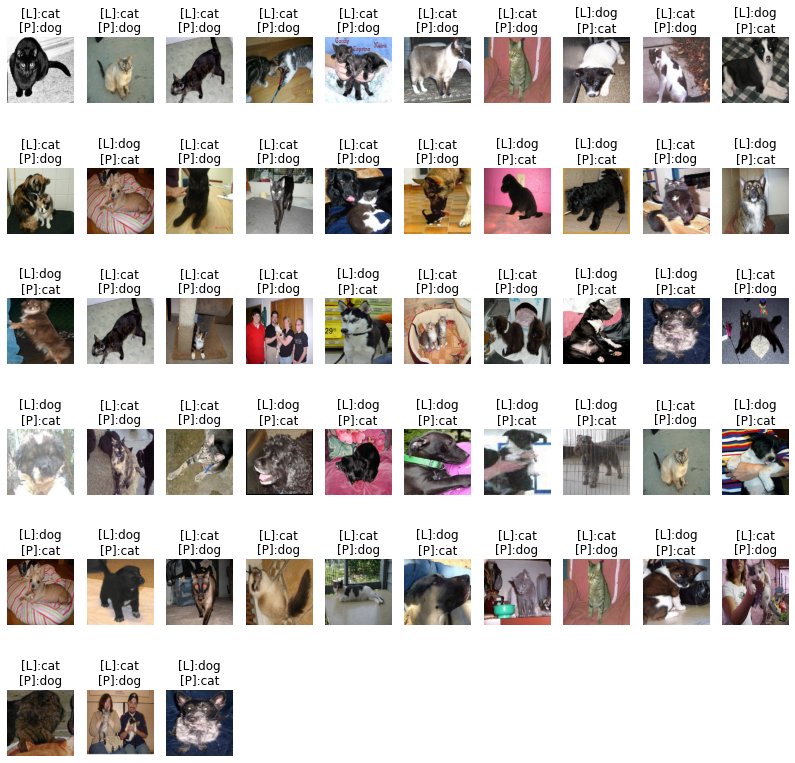

In [64]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(14, 14))
idx = np.nonzero(pre != y_batch)[0]
idx = idx[:200]
width = 10
height = len(idx) // width + 1
for i, d  in enumerate(idx):
    img, label, p = x_ori[d], y_batch[d], pre[d]
    t = "[L]:{}\n[P]:{}".format(trans[label], trans[p])
    plt.subplot(height, width, i+1)
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)